In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

from rasterio.plot import show
import rasterio as rio
import rasterio.features

import rioxarray as xrio
import xarray as xr
import xshape as xs
from datacube.utils.geometry import GeoBox     #https://datacube-core.readthedocs.io/

from ipypb import track
import os
import pickle

import warnings

warnings.simplefilter("ignore")

In [2]:
## set top level of OneDrive as home directory
home = "E:/University College London/O'Sullivan, Aidan - SDG6/"
os.chdir(home)

## location of corrected scenes
cor_path = home+"/Landsat data/Corrected data V2/"

## pixel exctraction location
px_path = home+"/Landsat data/Pixels2/"

<br>

#### Function for creating list of nighbours

In [30]:
def create_neighbours_list(xrds,point,k,max_dis):
    '''
    Select k nearest pixles in xarray raster dataset (excluding masked nan values)
        -xrds: xarray dataset 
        -ptxy: point as tuple (x,y) in the same crs as the xarray
        -k: number of pixels to select
    '''
    
    ## create coordinate list from array
    coords = xrds.to_dataframe().dropna(how='all').reset_index()[['x', 'y']].values #
    
    if len(coords)==0:
        print('No coordinates with not null values')
    
    x = coords[:,0]
    y = coords[:,1]

    ## calculate distance between point xy and grid xy
    x_dist = np.abs(x - ptxy[0])
    y_dist = np.abs(y - ptxy[1])

    ## calculate euclidean distance
    euc_dist = np.sqrt(x_dist**2 + y_dist**2)

    ## return max distance based on
    max_neighbour_dist = sorted(euc_dist)[k]

    ## limit selection to within max distance
    if max_neighbour_dist<max_dis:
        max_neighbour_dist = max_neighbour_dist
    else:
        max_neighbour_dist = 0

    neighbours_x = x[euc_dist<max_neighbour_dist]
    neighbours_y = y[euc_dist<max_neighbour_dist]
    
    ## creating boolean mask for meshgrid
    xm,ym = np.meshgrid(xrds.x.values,xrds.y.values)
    
    xm_dist = np.abs(xm - ptxy[0])
    ym_dist = np.abs(ym - ptxy[1])
    mesh_euc = np.sqrt(xm_dist**2 + ym_dist**2)
    
    mesh_mask = mesh_euc<max_neighbour_dist
    
    mesh_mask = xr.DataArray(mesh_mask, dims=("y","x"))

    #print(f'Number of coordinates returned: {len(neighbours_y)} \nDistance to furthest pixel {round(max_neighbour_dist,0)}')
    
    return mesh_mask, neighbours_x,neighbours_y

<br>

#### Function for masking original array to pixel coordinates

In [4]:
def mask_polygon(xrds,poly,buff):
    
    '''mask xarray based on polygon in crs of array and buffer distance'''
    
    ## Create mask as array
    shape_mask = rasterio.features.geometry_mask(poly.buffer(-buff).geometry,
                                          out_shape=(len(xrds.y), len(xrds.x)),
                                          transform=xrds.geobox.transform,
                                          invert=True)
    ## convert to xarray
    shape_mask = xr.DataArray(shape_mask, dims=("y", "x"))

    ## Then apply the mask
    xrds_masked = xrds.where(shape_mask == True, drop=True)
    
    return xrds_masked

In [5]:
def mask_coords(xrds,neighbours_x,neighbours_y):
    '''
    Mask xarray with two vectors of coordinates
        -x,y: lists or arrays of x and y coordinates of nearest neighbours or other pixels of interest
        -xrds: xarray with 2D x and y dimensions from with same shape as that used to create x and y list
    '''

    ## Create meshgrid of coordinates
    x = xrds.x.values
    y = xrds.y.values

    xm, ym = np.meshgrid(x,y)

    ## create boolean arrays based on whether coordinates are identified neighbours
    ymbools = np.isin(ym,neighbours_y)
    xmbools = np.isin(xm,neighbours_x)

    mbools = ymbools*xmbools
    
    ## create mask from boolean array
    pixel_mask = xr.DataArray(mbools, dims=("y","x"))

    ## Then apply the mask
    pixels = xrds.where(pixel_mask == True, drop=True)
    
    return pixels

### Read in list of sites for download and setup metadata

In [6]:
sites = pd.read_pickle("sites4.p")
#sites = sites.set_index(['sid','dt'])
sites = sites.set_geometry('geometry_poly')

<br>

### Construct xarray and exract pixels in a loop

In [7]:
## change directory
os.chdir(cor_path)

## list of files to process
dl_files = [ i for i in os.listdir() if '.tif' in i]

## unique site id scene entity id list
sid_eids = list(set([ i.split('__')[0]+'__'+i.split('__')[1][0:40] for i in dl_files]))

In [8]:
## set buffer distance for polygon masking
buff = 50

## set k pixels to extract
k = 9

## set maximum distance for nearest pixels
max_dis = 500

## list to append data
li = []

 [████████████████████████████████████████████████████████████] 20/20 [00:38<00:02, 1.91s/it]

pixels: 12, pixels df: 0
pixels2: 12, pixels2 df: 0


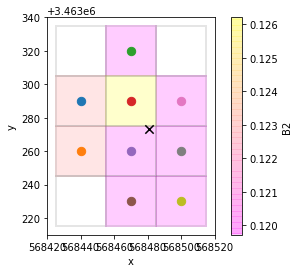

pixels: 12, pixels df: 12
pixels2: 12, pixels2 df: 9


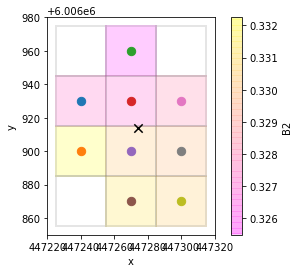

pixels: 18, pixels df: 9
pixels2: 27, pixels2 df: 9


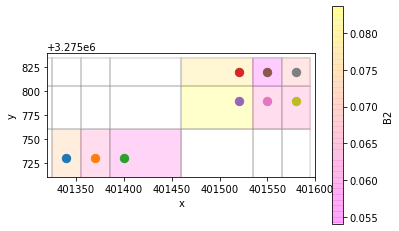

pixels: 16, pixels df: 11
pixels2: 32, pixels2 df: 9


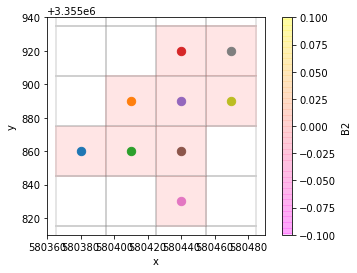

pixels: 9, pixels df: 9
pixels2: 9, pixels2 df: 9


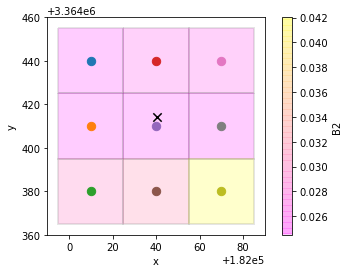

pixels: 12, pixels df: 9
pixels2: 12, pixels2 df: 9


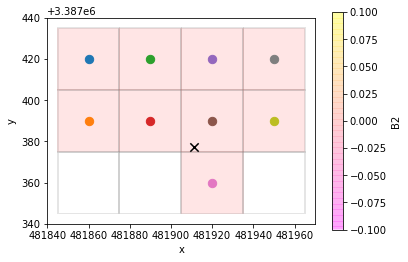

pixels: 12, pixels df: 12
pixels2: 12, pixels2 df: 9


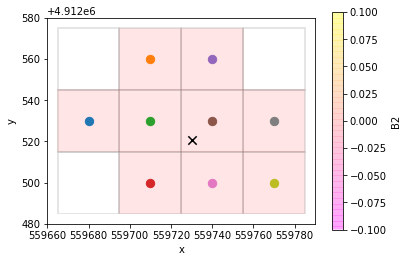

pixels: 12, pixels df: 12
pixels2: 12, pixels2 df: 9


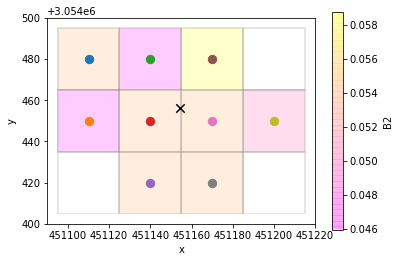

pixels: 9, pixels df: 9
pixels2: 9, pixels2 df: 9


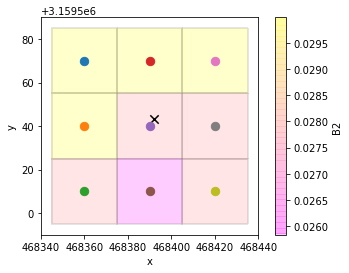

pixels: 24, pixels df: 12
pixels2: 32, pixels2 df: 9


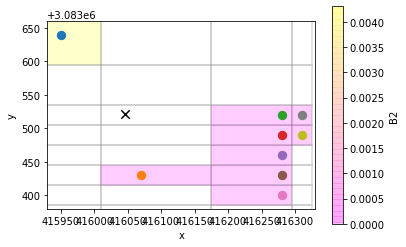

Pixel extraction failed for 21FLBRA-564A-B__LT05_L1TP_018039_20060930_20160909_01_T1
pixels: 24, pixels df: 12
pixels2: 32, pixels2 df: 9


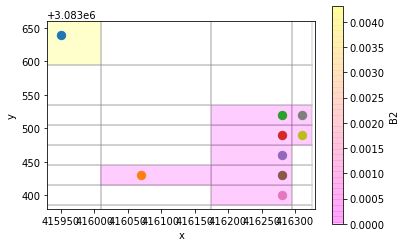

pixels: 9, pixels df: 9
pixels2: 9, pixels2 df: 9


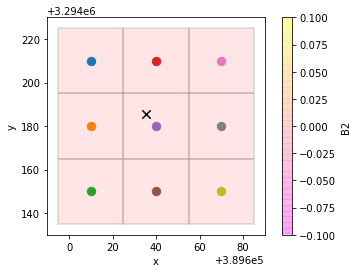

pixels: 9, pixels df: 9
pixels2: 9, pixels2 df: 9


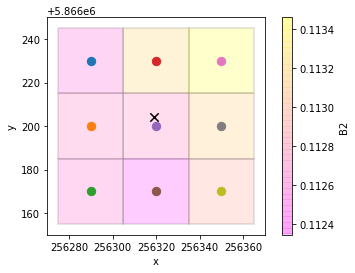

pixels: 12, pixels df: 5
pixels2: 12, pixels2 df: 5


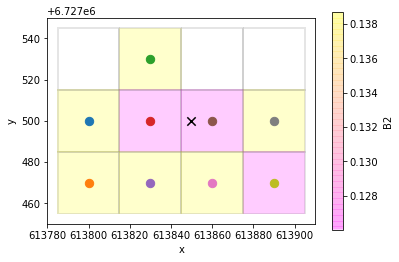

pixels: 12, pixels df: 12
pixels2: 12, pixels2 df: 9


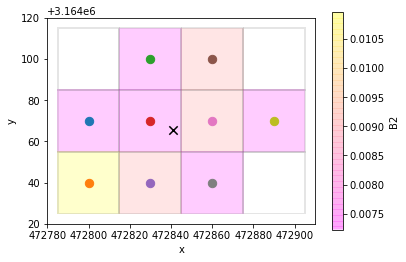

pixels: 12, pixels df: 12
pixels2: 12, pixels2 df: 9


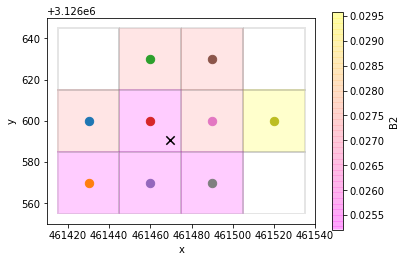

pixels: 9, pixels df: 9
pixels2: 9, pixels2 df: 9


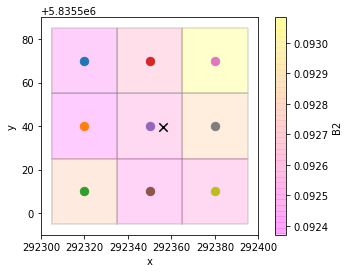

pixels: 15, pixels df: 13
pixels2: 25, pixels2 df: 9


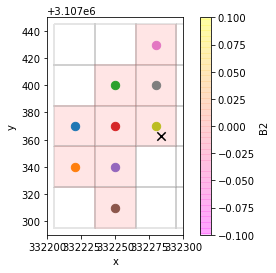

In [38]:
for sid_eid in track(sid_eids[0:20]):

    sid_eid_files = [ i for i in os.listdir(cor_path) if sid_eid in i]
    
    if sum(['B2' in i for i in sid_eid_files])>0:
    
        ## set sid and eid
        sid = sid_eid.split('__')[0]
        eid = sid_eid.split('__')[1][0:40]

        #~~~ construct xarray of all tifs~~~#

        ## get CRS of raster
        with rio.open(sid_eid_files[0]) as src:            

            ras_crs = src.crs

        src.close()

        ## read in first tif in list

        ## set band and correction
        band = sid_eid_files[0].split('__')[1][41:47].split('_')[0].replace('.','')
        correction = 'tre' if ('tre' in [ i for i in sid_eid_files if 'B2' in i][0]) else 'sre'

        xtif = xrio.open_rasterio(sid_eid_files[0],
                                  masked=True,
                                 default_name = band)

        xtif = xtif[0]

        ## add other tifs in a loop
        for adtif in sid_eid_files[1:len(sid_eid_files)]:

            band = adtif.split('__')[1][41:47].split('_')[0].replace('.','')

            ## read in subsequent tifs and merge
            ytif = xrio.open_rasterio(adtif,
                                      masked = True,
                                      default_name = band)

            ytif = ytif[0]
            xtif = xr.merge([xtif,ytif],compat='override')


        # Add attributes to combined xarray from last tif
        xtif.attrs = {key: ytif.attrs[key] for key in ytif.attrs.keys() & {'transform', 'scale_factor','add_offset','grid_mapping'}}
        xtif.attrs['shape'] = ytif.shape

        ## add crs
        xtif.attrs['crs'] = str(src.crs)

        ## add site id and entity id
        xtif.attrs['eid'] = eid
        xtif.attrs['sid'] = sid
        xtif.attrs['correction'] = correction

        ## load the dataset from memory
        xtif = xtif.load().drop(['band','spatial_ref'])



        #~~~ retrieve point and polygon from site data ~~~#

        ## retrieve monitoring location as point
        pt = sites.loc[sid,:].set_geometry('geometry_ll')[0:1]             

        ## change crs of pt
        original_crs = sites.crs
        pt = pt.to_crs(ras_crs)

        ## change crs of poly
        poly = pt.set_geometry('geometry_poly')
        poly.crs = original_crs
        poly = poly.to_crs(ras_crs) 



        # ~~~ mask xarray to lake polygon, find neighbours and mask xarray ~~~ #

        ptxy = (pt.geometry.x.values[0],pt.geometry.y.values[0])

        try:    
            xtif_masked = mask_polygon(xtif,poly,buff)

        except:
            print(f'Geometry invalid for rasterisation {sid}')

        try:
            mesh_mask,nx,ny = create_neighbours_list(xtif_masked,ptxy,k=k,max_dis=max_dis)

            pixels = mask_coords(xtif_masked,nx,ny)
            
            pixels2 = xtif_masked.where(mesh_mask == True, drop=True)

        except:
            print(f'Pixel extraction failed for {sid_eid}')

        #~~~ pixels to dataframe ~~~#

        if 'pixels' in locals():
            
            ## convert to dataframe
            pixels_df = pixels.to_dataframe()
            
            ## add metadata
            pixels_df['sid'] = sid
            pixels_df['eid'] = eid
            pixels_df['correction'] = correction
            
            print(f'pixels: {len(pixels.B2.values.flatten())}, pixels df: {len(pixels.to_dataframe().dropna())}')
            print(f'pixels2: {len(pixels2.B2.values.flatten())}, pixels2 df: {len(pixels2.to_dataframe().dropna())}')

            li.append(pixels_df)

            ## write pixels to netCDF
#             pixels.to_netcdf(px_path+sid_eid+'.nc',mode='w')
            
            
            if len(pixels['B3'].values.flatten())>0:
                
                fig, ax = plt.subplots()
                pixels2['B2'].plot.pcolormesh('x','y',cmap='spring',ax=ax,alpha=0.2,edgecolors='grey')
                pt.plot(ax=ax,marker='x',color='k',markersize=70)
                plt.xlim(nx.min()-20,nx.max()+20)
                plt.ylim(ny.min()-20,ny.max()+20)

                for i in range(len(nx)):

                    plt.scatter(nx[i],ny[i],s=70)


                plt.show()

df = pd.concat(li,axis=0)

In [47]:
pixels2.to_dataframe().dropna(how='any').reset_index()

,x,y,B1,B2,B3,B4,B5,B6,cirrus,cloud
0,332220.0,3107370.0,0.022211,0.0,0.014545,0.045645,0.012330,296.399780,3.0,1.0
1,332220.0,3107340.0,0.022211,0.0,0.014545,0.045645,0.012330,296.399780,3.0,1.0
2,332250.0,3107400.0,0.022211,0.0,0.011537,0.041865,0.014833,296.399780,3.0,1.0
3,332250.0,3107370.0,0.022211,0.0,0.011537,0.041865,0.012330,296.399780,3.0,1.0
4,332250.0,3107340.0,0.022211,0.0,0.014545,0.041865,0.009827,296.399780,3.0,1.0
5,332250.0,3107310.0,0.025708,0.0,0.011537,0.041865,0.017336,296.399780,3.0,1.0
6,332280.0,3107430.0,0.023959,0.0,0.011537,0.041865,0.012330,296.399780,3.0,1.0
7,332280.0,3107400.0,0.022211,0.0,0.008528,0.041865,0.012330,296.399780,3.0,1.0
8,332280.0,3107370.0,0.023959,0.0,0.011537,0.041865,0.017336,295.965179,3.0,1.0


In [345]:
mesh_mask

<xarray.DataArray (y: 14025, x: 14025)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: y, x

In [184]:
df.to_csv(home+'pixel_values.csv')

### Plot results

(3287490.0, 3288240.0)

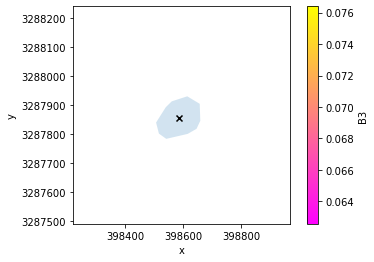

In [219]:
fig, ax = plt.subplots()

xtif_masked['B2'].plot(ax=ax,alpha=0.1)
poly.plot(ax=ax,alpha=0.2)
pixels['B3'].plot(ax=ax,cmap='spring')
pt.plot(ax=ax,marker='x',color='k')

ax.set_xlim(xtif.x.values.min(), xtif.x.values.max()) 
ax.set_ylim(xtif.y.values.min(), xtif.y.values.max())


### Extracting values

In [70]:
pixels.to_dataframe()

B10         B11        B2        B3        B4  \
x        y                                                                 
485100.0 5950020.0  272.158417  269.390167  0.225768  0.190861  0.175888   
         5949990.0  272.020905  269.116943  0.228609  0.199791  0.181796   
         5949960.0  271.806610  268.614807  0.245792  0.219635  0.203038   
485130.0 5950020.0  272.639618  269.885071  0.214944  0.182653  0.166011   
         5949990.0  272.545410  269.630829  0.218146  0.187028  0.169304   
         5949960.0  272.323151  269.095642  0.233661  0.211021  0.192530   
485160.0 5950020.0  273.057861  270.279358  0.204842  0.173408  0.155774   
         5949990.0  272.961060  270.015503  0.209442  0.175166  0.157487   
         5949960.0  272.700348  269.514099  0.218101  0.194018  0.175392   
485190.0 5950020.0  273.211975  270.419800  0.191898  0.164027  0.145175   
         5949990.0  273.106262  270.237183  0.199520  0.165380  0.148738   
         5949960.0  272.891388  269.892120  0.199836  0.167139  0.149324   

                          B5  cirrus  cloud  
x        y                                   
485100.0 5950020.0  0.288547     1.0    3.0  
         5949990.0  0.287239     1.0    3.0  
         5949960.0  0.309383     1.0    3.0  
485130.0 5950020.0  0.272446     1.0    3.0  
         5949990.0  0.278219     1.0    3.0  
         5949960.0  0.302573     1.0    3.0  
485160.0 5950020.0  0.258646     1.0    3.0  
         5949990.0  0.266087     1.0    3.0  
         5949960.0  0.282819     1.0    3.0  
485190.0 5950020.0  0.244349     1.0    3.0  
         5949990.0  0.255669     1.0    3.0  
         5949960.0  0.250483     1.0    3.0

### Loading netCDF files

In [174]:
test = xr.open_dataset(px_path+'NL92_RAMSDP__LC08_L1TP_197023_20140419_20170423_01_T1.nc')
test.load()
test['B2']

<xarray.DataArray 'B2' (y: 3, x: 3)>
array([[0.08867416, 0.08781593, 0.08698539],
       [0.08814815, 0.08778825, 0.08665317],
       [0.08836962, 0.08820351, 0.08670854]])
Coordinates:
  * x        (x) float64 2.923e+05 2.924e+05 2.924e+05
  * y        (y) float64 5.836e+06 5.836e+06 5.836e+06
Attributes:
    STATISTICS_MAXIMUM:  1
    STATISTICS_MEAN:     0.11538077964712
    STATISTICS_MINIMUM:  0.021732504419064
    STATISTICS_STDDEV:   0.033786505689275
    transform:           [ 3.000000e+01  0.000000e+00  2.860950e+05  0.000000...
    grid_mapping:        spatial_ref

In [175]:
test.close()

In [324]:
a = [1,2,3,4,5,6,7]
b = [1,2,3,4,5,6,8]

x,y = np.meshgrid(a,b)

sel = np.array([2,3,4,5])

ptxy = (2.5,3)

array([[2.5       , 2.06155281, 2.06155281, 2.5       , 3.20156212,
        4.03112887, 4.9244289 ],
       [1.80277564, 1.11803399, 1.11803399, 1.80277564, 2.6925824 ,
        3.64005494, 4.60977223],
       [1.5       , 0.5       , 0.5       , 1.5       , 2.5       ,
        3.5       , 4.5       ],
       [1.80277564, 1.11803399, 1.11803399, 1.80277564, 2.6925824 ,
        3.64005494, 4.60977223],
       [2.5       , 2.06155281, 2.06155281, 2.5       , 3.20156212,
        4.03112887, 4.9244289 ],
       [3.35410197, 3.04138127, 3.04138127, 3.35410197, 3.90512484,
        4.60977223, 5.40832691],
       [5.22015325, 5.02493781, 5.02493781, 5.22015325, 5.59016994,
        6.10327781, 6.72681202]])

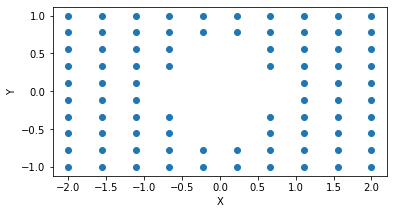

In [296]:
N = 10
x_start, x_end = -2.0, 2.0
y_start, y_end = -1.0, 1.0

x = np.linspace(x_start, x_end, N)
y = np.linspace(y_start, y_end, N)

x0, y0, radius = 0.0, 0.0, 0.7

x, y = np.meshgrid(x, y)
r = np.sqrt((x - x0)**2 + (y - y0)**2)

outside = r > radius

fig, ax = plt.subplots()
ax.set(xlabel='X', ylabel='Y', aspect=1.0)

ax.scatter(x[outside], y[outside])

plt.show()

In [297]:
outside

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False, False,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False, False,  True,  True,  True,
         True],
       [ True,  True,  True, False, False, False, False,  True,  True,
         True],
       [ True,  True,  True, False, False, False, False,  True,  True,
         True],
       [ True,  True,  True,  True, False, False,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False, False,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [347]:
xtif.shape

(207, 496)

In [14]:
## create coordinate list from array
coords = xtif_masked.to_dataframe().dropna(how='all').reset_index()[['x', 'y']].values #

if len(coords)==0:
    print('No coordinates with not null values')

x = coords[:,0]
y = coords[:,1]

x.shape

(8807,)

In [15]:
## calculate distance between point xy and grid xy
x_dist = np.abs(x - ptxy[0])
y_dist = np.abs(y - ptxy[1])

## calculate euclidean distance
euc_dist = np.sqrt(x_dist**2 + y_dist**2)

## return max distance based on
max_neighbour_dist = sorted(euc_dist)[k]

max_neighbour_dist

53.02183388917447

In [ ]:
## limit selection to within max distance
if max_neighbour_dist<max_dis:
    max_neighbour_dist = max_neighbour_dist
else:
    max_neighbour_dist = 0

neighbours_x = x[euc_dist<max_neighbour_dist]
neighbours_y = y[euc_dist<max_neighbour_dist]

In [23]:
## creating boolean mask for meshgrid
xm,ym = np.meshgrid(xtif_masked.x.values,xtif_masked.y.values)

xm_dist = np.abs(xm - ptxy[0])
ym_dist = np.abs(ym - ptxy[1])
mesh_euc = np.sqrt(xm_dist**2 + ym_dist**2)

mesh_mask = mesh_euc<max_neighbour_dist

mesh_mask = xr.DataArray(mesh_mask, dims=("y","x"))

In [24]:
mesh_mask

<xarray.DataArray (y: 181, x: 142)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: y, x

In [26]:
pixels2 = xtif_masked.where(mesh_mask==True,drop=True)

In [29]:
pixels2['B3']

<xarray.DataArray 'B3' (y: 4, x: 3)>
array([[       nan, 0.24321389,        nan],
       [0.24480742, 0.24490702, 0.2455046 ],
       [0.25068361, 0.24839289, 0.24709813],
       [       nan, 0.24779531, 0.24689895]])
Coordinates:
  * x        (x) float64 4.472e+05 4.473e+05 4.473e+05
  * y        (y) float64 6.007e+06 6.007e+06 6.007e+06 6.007e+06
Attributes:
    STATISTICS_MAXIMUM:  1
    STATISTICS_MEAN:     0.49303346634699
    STATISTICS_MINIMUM:  0.20845481948103
    STATISTICS_STDDEV:   0.18897829040371
    transform:           (30.0, 0.0, 446085.0, 0.0, -30.0, 6007665.0)
    scale_factor:        1.0
    add_offset:          0.0
    grid_mapping:        spatial_ref